In [69]:
from datasets import load_dataset
import os
# import pytorch_lightning as py
import torch.utils.data as data
from torch.utils.data import DataLoader
import torch
import pandas as pd
import gzip
# import glob
import tarfile
from PIL import Image
import io
from scipy.io import loadmat 
import matplotlib.pyplot as plt
import numpy as np
import cv2 as cv
import numpy as np
from torchvision import transforms
import torch.nn as nn

In [3]:
if torch.cuda.is_available():
    print(f"running cuda on device: {torch.cuda.current_device()}")
    device = torch.device("cuda")    
else:
    print(f"no cuda device found")
    device = torch.device("cpu")    


running cuda on device: 0


In [4]:
class DepthDataSet(data.Dataset):
    def __init__(self, path, depth=False):
        # self.files = glob.glob(f"{path}/*.tar.gz")
        self.paths = path
        self.path_file_map = []
        self.data = []
        self.files = os.listdir(path)
        self.labels = []
        self.depth = depth

        # print(self.files)
        for file in self.files:
            # with tarfile.open(file, 'r') as f:
                # data = pd.read_csv(f)
            with tarfile.open(f'{path}/{file}','r:gz') as f:
                for member in f.getmembers():
                    if f.extractfile(member):    
                        self.data.append(member)
                        # print(member)
                        label = os.path.basename(os.path.dirname(member.name))
                        # print(label)
                        
                        #map the label of the image to the correct file
                        self.labels.append(label)
                        self.path_file_map.append(file)


        # self.label_to_index = {label: i for i, label in enumerate(sorted(set(self.labels)))}

                # print(f.extractall())
                # t_file = f.ex
                # for tarfile in f.extractall():
                    # print(tarfile)
                # self.data.extend([img for img in f.getmembers()])
                # data = pd.read_csv(f.extractall,compression='gzip', header=0, sep=' ', quotechar='"', encoding=bytes)    
                # self.data.append(data)
        
        # self.data = pd.concat(self.data)

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        path = self.path_file_map[index]
        # print('path =',path)

        # path = "Train400Img.tar.gz" if self.labels[index] == "" else self.labels[index]

        # print('data =',self.data[index])
        
        with tarfile.open(f'{self.paths}/{path}', 'r:gz') as tf:
            file = tf.extractfile(self.data[index])
            
            # image = tf.getmember(self.data[index])
            if(self.depth == False):
                img = Image.open(io.BytesIO(file.read()))
                toTensor = transforms.ToTensor()
                img = toTensor(img)
            # label = self.label_to_index[self.labels[index]]
                # if(torch.cuda.is_available()):
                #     img = img.to('cuda')
                img.to(device)
                # print(img)
                return img
        
            else:
                img = loadmat(io.BytesIO(file.read()))
                # matObj = plt.mat    
                # print(img)

                img = img.get("Position3DGrid")
                
                depth = img[:,:,3]
                depth = np.log1p(depth)

                target = (1704,2272)

                depth_resized = cv.resize(depth, target, interpolation=cv.INTER_CUBIC)
                depth_resized = cv.normalize(depth_resized, None, 0, 255, cv.NORM_MINMAX)
                depth_resized = depth_resized.astype(np.uint8)

                depth_resized = np.expand_dims(depth_resized,axis=2)

                depth_resized = torch.from_numpy(depth_resized).permute(2,0,1).float() / 255.0

                # if(torch.cuda.is_available()):
                #     depth_resized = depth_resized.to('cuda')
                depth_resized.to(device)
                
                # print(depth_resized)

                # depth = img[:,:,3]
                # max_depth = depth.max()
                # depth = Image.fromarray(depth.astype(np.float32))
                # print(depth)

                # # print(depth)
                # depth = depth/max_depth
                
                # print(depth)

                # depth = depth.resize((2272,1704))
                # print(img)
                # print(img[:,:,2])
                return depth_resized

In [5]:
train_img_dataset = DepthDataSet(path='./data/train/imgs')

In [6]:
train_depth_dataset = DepthDataSet(path='./data/train/depths',depth=True)

In [7]:
print(len(train_img_dataset))
print(len(train_depth_dataset))


400
400


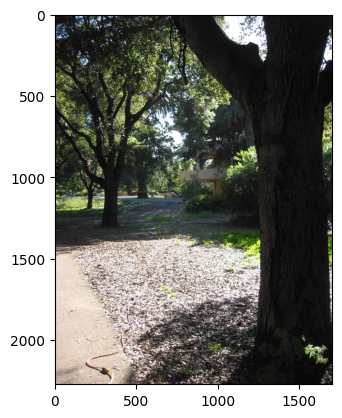

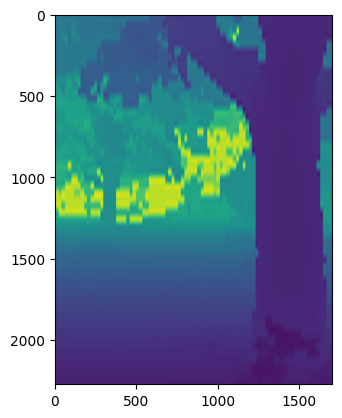

In [8]:
index=193
image = train_img_dataset[index]
image = image.cpu().permute(1,2,0).numpy()
plt.imshow(image)
plt.show()

depth_map = train_depth_dataset[index]
depth_map = depth_map.cpu().permute(1,2,0).numpy()
plt.imshow(depth_map)
plt.show()

In [ ]:
class Encoder(nn.Module):
    def __init__(self, image_batch=8):
        super(Encoder2,self).__init__()

        #(2272, 1704, 3) -> (2272, 1704, 16)
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3,out_channels=16,kernel_size=5,stride=5,padding=2),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True)
        )
        

        #(568, 426, 32) -> (568, 426, 64)
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=16,out_channels=32,kernel_size=3,stride=3,padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True)
        )


        #(284, 213, 64) -> (95, 71, 32)
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=32,out_channels=16,kernel_size=3,stride=3,padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True)
        )

        #flatten

        self.fully_c1 = nn.Sequential(
            nn.Linear(51*38*16*image_batch,25*16*8),
            nn.ReLU(inplace=True)
        )
        self.fully_c2 = nn.Sequential(
            nn.Linear(25*16*8, 10*8*4)
        )
        # self.fully_c3 = nn.Linear(20*16*8, 5*4*2)

    def forward(self, x):
        print("{:20s} {}".format("Input Shape:",np.shape(x)))

        x = self.conv1(x)
        print("{:20s} {}".format("Conv1:",np.shape(x)))

        x = self.conv2(x)
        print("{:20s} {}".format("Conv2:",np.shape(x)))

        x = self.conv3(x)
        print("{:20s} {}".format("Conv3:",np.shape(x)))

        x = x.flatten()
        print("{:20s} {}".format("Flatten:",np.shape(x)))

        x = self.fully_c1(x)
        print("{:20s} {}".format("Fully Conn L1:",np.shape(x)))

        x = self.fully_c2(x)
        print("{:20s} {}".format("Fully Conn L2:",np.shape(x)))

        # x = self.fully_c3(x)
        # print("{:20s} {}".format("Fully Connected Layer 3:",np.shape(x)))
        return x


In [ ]:
encoder = Encoder()

In [85]:
img_dataloader = DataLoader(train_img_dataset,batch_size=8,shuffle=True)

In [86]:
data = next(iter(img_dataloader))
output = encoder(data)

Input Shape:         torch.Size([8, 3, 2272, 1704])
Conv1:               torch.Size([8, 16, 455, 341])
Conv2:               torch.Size([8, 32, 152, 114])
Conv3:               torch.Size([8, 16, 51, 38])
Flatten:             torch.Size([248064])
Fully Conn L1:       torch.Size([3200])
Fully Conn L2:       torch.Size([320])


In [55]:
for i,data in enumerate(img_dataloader):
    print(data)

tensor([[[[0.0902, 0.1216, 0.1098,  ..., 0.0980, 0.1059, 0.3686],
          [0.1020, 0.0863, 0.0706,  ..., 0.0784, 0.1373, 0.4549],
          [0.0706, 0.0784, 0.0706,  ..., 0.0549, 0.2039, 0.3882],
          ...,
          [0.2314, 0.2431, 0.2471,  ..., 0.1176, 0.1255, 0.1373],
          [0.2118, 0.2275, 0.2314,  ..., 0.1098, 0.1098, 0.1216],
          [0.1961, 0.2078, 0.2118,  ..., 0.1059, 0.1059, 0.1137]],

         [[0.0902, 0.1255, 0.1451,  ..., 0.2314, 0.2549, 0.5294],
          [0.1020, 0.0902, 0.1059,  ..., 0.2039, 0.2784, 0.6039],
          [0.0863, 0.0941, 0.1020,  ..., 0.1647, 0.3373, 0.5373],
          ...,
          [0.1725, 0.1922, 0.2078,  ..., 0.1176, 0.1333, 0.1451],
          [0.1686, 0.1882, 0.1961,  ..., 0.1176, 0.1294, 0.1412],
          [0.1608, 0.1725, 0.1843,  ..., 0.1137, 0.1255, 0.1333]],

         [[0.0902, 0.1412, 0.1647,  ..., 0.1765, 0.2039, 0.4745],
          [0.1098, 0.1059, 0.1255,  ..., 0.1529, 0.2314, 0.5529],
          [0.0902, 0.1059, 0.1098,  ..., 0

KeyboardInterrupt: 

In [27]:
class DepthNet(nn.Module):
    def __init__(self,)

SyntaxError: expected ':' (3765621902.py, line 2)